In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
% matplotlib inline

In [2]:
#Steps to generate
T = 5000

# Specify the hazard function.
# This is a handle to a function that takes one argument - the number of
# time increments since the last changepoint - and returns a value in
# the interval [0,1] that is the probability of changepoint.  Generally
# you might want to have your hazard function take parameters, so using
# an anonymous function is helpful.  We're going to just use the simple
# constant-rate hazard function that gives geomtrically-drawn intervals between changepoints.  
# We'll specify the rate via a mean.

lambd = 0.001
def hazard_func(r):
    return lambd

# This data is Gaussian with unknown mean and variance.  We are going to
# use the standard conjugate prior of a normal-inverse-gamma.  Note that
# one cannot use non-informative priors for changepoint detection in
# this construction.  The NIG yields a closed-form predictive
# distribution, which makes it easy to use in this context.  There are
# lots of references out there for doing this kind of inference - for
# example Chris Bishop's "Pattern Recognition and Machine Learning" in
# Chapter 2.  Also, Kevin Murphy's lecture notes.

mu0    = 0
kappa0 = 1
alpha0 = 1
beta0  = 1

# This will hold the data.  Preallocate for a slight speed improvement.
X = np.zeros(T)

# Store the times of changepoints.  It's useful to see them.
CP = [0]

In [3]:
# Generate the initial parameters of the Gaussian from the prior.
curr_ivar = np.random.gamma(alpha0)/beta0;
curr_mean = pow((kappa0*curr_ivar),(-0.5))*np.random.normal() + mu0;

In [4]:
#The initial run length is zero
curr_run = 0;

In [5]:
#Now, loop forward in time and generate data.
for t in range(0,T):
    # Get the probability of a new changepoint.
    p = hazard_func(curr_run)
    
    # Randomly generate a changepoint, perhaps.
    if np.random.uniform() < p:
        
        # Generate new Gaussian parameters from the prior.
        curr_ivar = np.random.gamma(alpha0)*beta0
        curr_mean = pow((kappa0*curr_ivar), (-0.5))*np.random.normal() + mu0
        
        # The run length drops back to zero.
        curr_run = 0
        
        # Add this changepoint to the end of the list.
        CP.append(t)
    else:
        # Increment the run length if there was no changepoint.
        curr_run = curr_run + 1
        
    # Draw data from the current parameters.
    X[t] = pow(curr_ivar, (-0.5)) * np.random.normal() + curr_mean

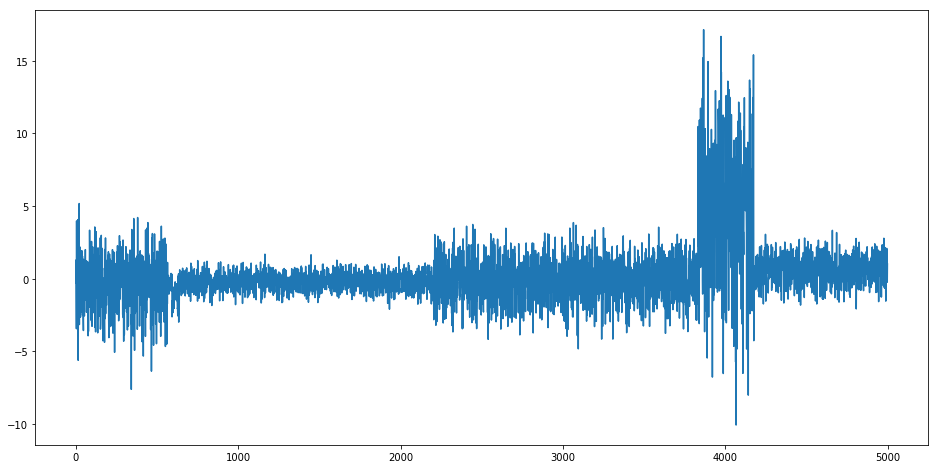

In [6]:
plt.figure(figsize=(16,8))
plt.plot(range(0,T), X)

In [7]:
import bayesian_online_changepoint_detection as bcod

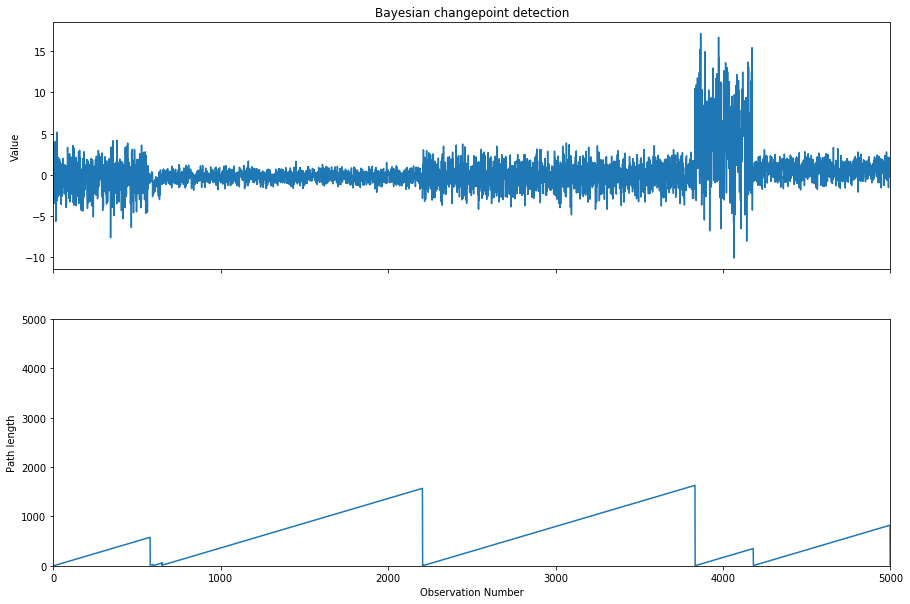

In [8]:
bayes_detector = bcod.Detector()
result, most_probable_path = bayes_detector.inference(X)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10), sharex=True)

ax1.set_xlim(0, T)
ax1.set_ylabel('Value')
ax1.set_title("Bayesian changepoint detection")

ax2.set_xlim(0, T)
ax2.set_ylim(0, T)
ax2.set_ylabel('Path length')
ax2.set_xlabel('Observation Number')

ax1.plot(range(0,T), X)
ax2.plot(range(0,T + 1), most_probable_path)